In [3]:
parent_path='../Data/New_Data_15-06-2020/'
%load_ext autoreload
%autoreload 2
import parmap
import pandas as pd
from tqdm import tqdm,tqdm_notebook
from utils.marking_similars import *
from utils.preprocess import *
import seaborn as sns

from utils.visualisation import *
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
# seed the random number generator
seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
whatsapp_data=pd.read_csv(parent_path+'Data_text_spam_removed_v02_hi_en.csv')
temp=whatsapp_data[['group_id_anonymized','phone_num_anonymized','message_text','timestamp']]
duplicateDFRow = temp[temp.duplicated()]
whatsapp_data=whatsapp_data.drop(list(duplicateDFRow.index))

In [ ]:
#whatsapp_data.to_csv(parent_path+'Data_text_spam_removed_v02_hi_en.csv',index=False)

In [ ]:
from langdetect import detect
from langdetect import DetectorFactory

DetectorFactory.seed = 0

def add_language(df):
    language= []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        try:
            lang=detect(row["message_text"])
            language.append(lang)
        except:
            language.append('unk')

    df["language"] = language
    return df

n_process=30


df_split = np.array_split(whatsapp_data, n_process)
list_all = parmap.map(add_language, df_split,pm_processes=n_process,pm_pbar=True)
whatsapp_data=pd.concat(list_all,axis=0)


In [ ]:
whatsapp_data=whatsapp_data.sort_values('timestamp')
start_time=whatsapp_data.iloc[0]['timestamp']
end_time=whatsapp_data.iloc[-1]['timestamp']


In [ ]:
whatsapp_data=whatsapp_data[whatsapp_data['language'].isin(['hi','en'])]
whatsapp_data

In [ ]:
n_process=30
params_preprocess={'remove_numbers': True, 'remove_emoji': True, 'remove_stop_words': False, 'tokenize': True}

def preprocess_split(df):
    preprocessed_sents=[preprocess_sent(ele,params=params_preprocess) for ele in df['message_text']]
    df['preprocessed']=preprocessed_sents
    return df



def data_stats_whole(df):
    df_grouped=df.groupby('group_id_anonymized')
    
    df_users=df.groupby('phone_num_anonymized')
    user_per_group=df.groupby('group_id_anonymized').phone_num_anonymized.nunique()
    ###average_user
    average_user =0
    for user in user_per_group.items():
        average_user+=user[1]
    average_user/= len(df_grouped)
    ###average_message
    average_message=0
    for group in df_grouped.groups.keys():
        average_message+=len(df_grouped.get_group(group))
    average_message/= len(df_grouped)   
    
    ###average message length in chars
    df_split = np.array_split(df, n_process)
    list_all = parmap.map(preprocess_split, df_split,pm_processes=n_process,pm_pbar=True)
    df=pd.concat(list_all,axis=0)
    
    sum1=0
    for index,row in tqdm(df.iterrows(),total=df.shape[0]):
        sum1+=len(row['preprocessed'])
    average_message_length= sum1/len(df)  
    
    
    
    dict1={}
    dict1["Total dataset"]=len(df)
    dict1["Total groups"]=len(df_grouped)
    dict1["Total users"]=len(df_users)
    dict1["Total languages"]=len(df.groupby('language'))
    dict1["Average number of user per group"]=int(average_user)
    dict1["Avg number of messages per group"]=int(average_message)
    dict1["Unique users in total"]=int(len(df['phone_num_anonymized'].unique()))
    dict1["Average message length in chracters per group"]=int(average_message_length)
    return dict1



data_stats_whole(whatsapp_data)

In [ ]:
thresh_to_consider = 0.8
signature_obj=Signature(10)


def remove_duplicates_within(sample_df):
    sample_df=signature_obj.add_signatures(sample_df)
    id_done=0
    duplicate={}
    row_repeated=[]
    for index,row in tqdm(sample_df.iterrows(),total=len(sample_df)):
        
        id_done+=1
        try:
            temp_dupl=duplicate[index]
            continue
        except KeyError:
            temp_repeated=row['repeated']
            temp=sample_df[id_done:]
            for index1,row1 in temp.iterrows():
                try:
                    temp_dupl=duplicate[index]
                    continue
                except KeyError:
                    signature1=row['signatures']
                    signature2=row1['signatures']
                    count=0
                    for k in range(0, signature_obj.numHashes):
                        count = count + (signature1[k] == signature2[k])
                    # add to tuple similar if greater than thresh    
                    if((count/signature_obj.numHashes)>thresh_to_consider):
                        duplicate[index1]=1
                        temp_repeated+=row1['repeated']
            temp_repeated=list(set(temp_repeated))
            row_repeated.append(temp_repeated)
    sample_df=sample_df.drop(list(duplicate.keys()))
    sample_df['repeated']=row_repeated
    return sample_df

In [5]:
annotated_df=pd.read_pickle(parent_path+'Fearspeech_data.pkl')
annotated_df=remove_duplicates_within(annotated_df)

NameError: name 'remove_duplicates_within' is not defined

In [ ]:
import numpy as np

countrepeat_list=[]
count_missing=0
for index,row in annotated_df.iterrows():
    if(len(row['repeated'])>0):
        countrepeat_list.append(len(row['repeated']))
    else:
        countrepeat_list.append(0)
        count_missing+=1
annotated_df['times_repeated']=countrepeat_list

In [ ]:
annotated_df=annotated_df[annotated_df['times_repeated']>0]

In [10]:
annotated_df=pd.read_pickle(parent_path+'Fearspeech_data_final.pkl')

#silver_df=pd.read_pickle(parent_path+'Fearspeech_data_silver.pkl')


#annotated_df=pd.concat([annotated_df,silver_df])

In [11]:
annotated_df

,Annotation1,Annotation2,Annotation3,User1,User2,User3,forwarded,group_id_anonymized,group_type,hindu_keyword_count,...,pred_probab,preds,repeated,timestamp,tokenized,translated,unique_ids,signatures,one_fear_speech,times_repeated
0,Fear speech,Fear speech,Normal,Adarsh,Yuvraj,Vineeth,1.0,7.0,BJP,1.0,...,0.030909,0.0,"[26904.0, 5559349.0]",1.550186e+12,"[प्रशासक, समिति, raised_fist, triangular_flag,...",* Administrator ✊ 🚩 Committee * ● ●●●●●●●●●●...,"[bf7a79ae-f605-4b16-86a8-0fab7d1d8dc8, 8dff263...","[190121731, 83544920, 6727897, 5326334, 582284...",1,2
1,Normal,Normal,Normal,Adarsh,Yuvraj,Vineeth,1.0,7.0,BJP,1.0,...,0.004815,0.0,"[5722016.0, 6275453.0, 3841610.0, 4591312.0, 2...",1.550921e+12,"[हैदराबाद, की, मक्का, मस्जिद, में, ब्लास्ट, मर...",Blast 16 killed and 100 injured in Hyderabad's...,"[7ee2ce95-7967-4514-ad12-e082cd80d994, 0511697...","[92668893, 116132756, 243624917, 380133676, 37...",0,11
2,Fear speech,Fear speech,Normal,Divyanshu,Adarsh,Vineeth,1.0,51.0,BJP,0.0,...,0.684925,1.0,"[913665.0, 2533382.0, 2649481.0, 2700434.0, 52...",1.551149e+12,"[(, ), ``, इस्लाम, धर्म, नहीं, एक, मानसिक, रोग...","* (1) - ""Islam is not a religion but a mental ...","[90bc3ab7-0148-4761-9756-d54592a270b2, 9b89d01...","[105464831, 5566639, 22142976, 16806931, 15938...",1,20
3,Fear speech,Normal,Normal,Divyanshu,Sharat,Kukkadapu,1.0,30.0,BJP,0.0,...,0.055631,0.0,[89540.0],1.551532e+12,"[पाकिस्तान, से, अधिक, तो, जमातएइस्लामी, के, सं...",Jamaat-e-Islami has more resources than Pakist...,"[e230abbc-1869-4614-852c-e9d2f34b2a0a, 14946c4...","[229503663, 85790611, 18620710, 210381345, 158...",0,1
4,Normal,Normal,Fear speech,Sharat,Adarsh,Vineeth,1.0,75.0,BJP,13.0,...,0.014175,0.0,"[4997140.0, 4995610.0, 1023004.0, 4463133.0, 1...",1.552123e+12,"[शहरी, नक्सलवाद, माओवाद, ।, बस, एक, निवेदन, पढ...",Urban Naxalism Maoism. Just a request… start r...,"[96f6b93f-a84e-43fb-bfdc-7082c2f75a59, e3b7d48...","[17345458, 310604, 13898869, 9356552, 91665, 6...",0,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5333,Fear speech,Normal,Normal,Divyanshu,Kukkadapu,Yuvraj,1.0,9860.0,HINDU,13.0,...,0.910150,1.0,[6241993.0],1.538751e+12,"[हिन्दुओं, से, बेशर्म, कोई, जाति, पूरा, पढ़े, ...",I also apologize to the Hindus for the shamele...,"[6f2e361b-3a44-423a-acce-9b0f32b40c7a, 60bd983...","[23152460, 10641181, 13654549, 391627, 8115877...",0,1
5334,Fear speech,Fear speech,Fear speech,Kukkadapu,Yuvraj,Vineeth,65.0,9860.0,HINDU,2.0,...,0.976954,1.0,[6242185.0],1.532956e+12,"[अब, भी, नही, जागे, तो, मधेपुरा, पूर्णिया, में...","Even if you do not wake up, then in Madhepura ...","[c2ba87ff-c661-464f-8312-b1d6ee69698f, ec96a32...","[2364716, 37555518, 44045896, 72009804, 329955...",1,1
5335,Normal,Normal,Fear speech,Divyanshu,Kukkadapu,Vineeth,1.0,252.0,BJP,3.0,...,0.961367,1.0,[6257600.0],1.544080e+12,"[इतिहास, का, सबसे, बड़ा, छल, हिंदुओं, के, साथ,...",The biggest trick of history happened to Hindu...,"[98f83e20-3480-4af8-bb6c-6f40707010f9, fb13e8d...","[258028782, 179495400, 41236862, 4270146, 3634...",0,1
5336,Fear speech,Fear speech,Normal,Kukkadapu,Yuvraj,Vineeth,1.0,4532.0,BJP,11.0,...,0.937534,1.0,[6269592.0],1.562183e+12,"[फिर, कहते, हैं, #, राममन्दिर, नहीं, बना, ____...",Then it says #Ramandir is not made ___________...,"[461a69c9-b8e7-4d86-9e22-f759ab5a2847, 45cb633...","[134021, 9506925, 7050110, 953206, 11604874, 8...",1,1


In [12]:
all_fear_speech_index=[]
all_normal_index=[]

count_fearspeech=0
count_normal=0

for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    if(row['one_fear_speech']==1):
        count_fearspeech+=1
        all_fear_speech_index+=row['repeated']
    elif(row['one_fear_speech']==0):
        count_normal+=1
        all_normal_index+=row['repeated']

data_fear_speech=whatsapp_data[whatsapp_data['orig_index'].isin(all_fear_speech_index)]
data_normal=whatsapp_data[whatsapp_data['orig_index'].isin(all_normal_index)]


100%|██████████| 4782/4782 [00:00<00:00, 12122.82it/s]


In [13]:
sns.color_palette()[1]

(1.0, 0.4980392156862745, 0.054901960784313725)

In [14]:
all_fear_speech_pairs=[]
all_normal_pairs=[]


for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    if(row['one_fear_speech']==1):
        data_fear_speech=whatsapp_data[whatsapp_data['orig_index'].isin(row['repeated'])]
        if(len(data_fear_speech)==0):
            continue
        sample=data_fear_speech.sample(min(len(data_fear_speech),3))
        
        
        for index1,row1 in sample.iterrows():
            all_fear_speech_pairs.append([row['message_text'],row1['message_text']])
    elif(row['one_fear_speech']==0):
        data_normal=whatsapp_data[whatsapp_data['orig_index'].isin(row['repeated'])]
        if(len(data_normal)==0):
            continue
        sample=data_normal.sample(min(len(data_normal),3))
                
        for index1,row1 in sample.iterrows():
            all_normal_pairs.append([row['message_text'],row1['message_text']])



100%|██████████| 4782/4782 [00:32<00:00, 146.83it/s]


In [15]:
with open('duplicate_pair_binny.txt', 'w') as f:
    for item in random.sample(all_normal_pairs,50):
        f.write("====================Start=======================\n")
        f.write("*************Original*********\n")
        f.write("%s\n" % item[0])
        f.write("*************Duplicate found*********\n")
        f.write("%s\n" % item[1])
        
        
with open('duplicate_pair_punyajoy.txt', 'w') as f:        
    for item in random.sample(all_fear_speech_pairs,50):
        f.write("====================Start=======================\n")
        f.write("*************Original*********\n")
        f.write("%s\n" % item[0])
        f.write("*************Duplicate found*********\n")
        f.write("%s\n" % item[1])


In [ ]:
len(data_fear_speech)

In [16]:
print("Fear speech:",len(annotated_df[annotated_df['one_fear_speech']==1]))
print("Normal:",len(annotated_df[annotated_df['one_fear_speech']==0]))

Fear speech: 1142
Normal: 3640


In [17]:
def data_stats(df,whatsapp_data):
    df_groups=df.group_id_anonymized.unique()
   
    average_user_per_group= 0
    for group in df_groups:
        number_of_users=whatsapp_data[whatsapp_data['group_id_anonymized']==group].phone_num_anonymized.nunique()
        average_user_per_group+=number_of_users
    average_user_per_group/= len(df_groups)
    
    average_message_per_group= 0
    for group in df_groups:
        num_of_messages=len(whatsapp_data[whatsapp_data['group_id_anonymized']==group])
        average_message_per_group+=num_of_messages
    average_message_per_group/= len(df_groups)
    
    average_fear_user_per_group= 0
    for group in df_groups:
        number_of_users=df[df['group_id_anonymized']==group].phone_num_anonymized.nunique()
        average_fear_user_per_group+=number_of_users
    average_fear_user_per_group/= len(df_groups)
    
    average_fear_message_per_group= 0
    for group in df_groups:
        num_of_messages=len(df[df['group_id_anonymized']==group])
        average_fear_message_per_group+=num_of_messages
    average_fear_message_per_group/= len(df_groups)
    
    df_users=df.phone_num_anonymized.unique()
    
    avg_number_group_per_users=0
    for user in df_users:
        number_of_users=whatsapp_data[whatsapp_data['phone_num_anonymized']==user].group_id_anonymized.nunique()
        avg_number_group_per_users+=number_of_users
    avg_number_group_per_users/=len(df_users)
    
    
    average_fear_message_per_user= 0
    for user in df_users:
        num_of_messages=len(df[df['phone_num_anonymized']==user])
        average_fear_message_per_user+=num_of_messages
    average_fear_message_per_user/= len(df_users)
    
    average_message_per_user= 0
    for user in df_users:
        num_of_messages=len(whatsapp_data[whatsapp_data['phone_num_anonymized']==user])
        average_message_per_user+=num_of_messages
    average_message_per_user/= len(df_users)

    ###average message length in chars
    sum1=0
    for index,row in tqdm(df.iterrows(),total=df.shape[0]):
        sum1+=len(preprocess_sent(row["message_text"],params={'remove_numbers': True, 'remove_emoji': True, 'remove_stop_words': False, 'tokenize': True}))
    average_message_length= sum1/len(df)
        
    
    dict1={}
    
    dict1["Total message"]=len(df)
    dict1["Total unique message"]=len(annotated_df[annotated_df['one_fear_speech']==1])
    dict1["Total users having atleast one fear speech (Fear speech users)"]=len(df_users)
    dict1["Total groups having atleast one fear speeach (Fear speech groups)"]=len(df_groups)
    dict1["Total languages"]=len(df.groupby('language'))
    dict1["Average number of users in Fear speech group"]=int(average_user_per_group)
    dict1["Average number of message in Fear speech group"]=int(average_message_per_group)
    dict1["Average number of fear speech users  in Fear speech group"]=int(average_fear_user_per_group)
    dict1["Average number of fear speech in Fear speech group"]=int(average_fear_message_per_group)
    dict1["Average number of groups by Fear speech users"]=int(avg_number_group_per_users)
    dict1["Average number of fear messages by Fear speech users"]=int(average_fear_message_per_user)
    dict1["Average number of messages by Fear speech users"]=int(average_message_per_user)
    dict1["Average message length of fear speech messages"]=int(average_message_length)
    return dict1

In [18]:
data_stats(data_normal,whatsapp_data)

100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


{'Total message': 1,
 'Total unique message': 1142,
 'Total users having atleast one fear speech (Fear speech users)': 1,
 'Total groups having atleast one fear speeach (Fear speech groups)': 1,
 'Total languages': 1,
 'Average number of users in Fear speech group': 43,
 'Average number of message in Fear speech group': 288,
 'Average number of fear speech users  in Fear speech group': 1,
 'Average number of fear speech in Fear speech group': 1,
 'Average number of groups by Fear speech users': 1,
 'Average number of fear messages by Fear speech users': 1,
 'Average number of messages by Fear speech users': 33,
 'Average message length of fear speech messages': 1408}

In [19]:
repeat_tuples=[]
fear_speech_count=0
for index,row in annotated_df.iterrows():
    if(row['one_fear_speech']==1):
        repeat_tuples.append([index,len(row['repeated']),'Fear speech'])
        fear_speech_count+=len(row['repeated'])
    else:
        repeat_tuples.append([index,len(row['repeated']),'Non Fear speech'])

In [20]:
df_repeat=pd.DataFrame(repeat_tuples,columns=['msg_id','num_repeats','label'])


In [21]:
# generate two independent samples
# compare samples
stat, p = mannwhitneyu(df_repeat[df_repeat['label']=='Fear speech'].num_repeats, df_repeat[df_repeat['label']=='Non Fear speech'].num_repeats)
print('Statistics=%.3f, p=%.5f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=1909643.000, p=0.00001
Different distribution (reject H0)


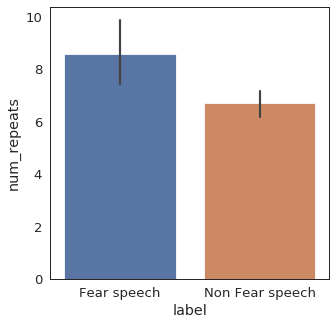

In [22]:
matplotlib.rcParams['figure.figsize'] = (5, 5)

#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=1.5)

font = {
    'weight' : 'normal',
    'size'   : 11}
ax = sns.barplot(x="label", y="num_repeats", data=df_repeat)
#g=add_values(g,df_admin,15,order_list)
plt.savefig('../Fear_speech_results/number_of_repeats.pdf',bbox_inches='tight',dpi=400)

In [23]:
num_groups_affected=[]
for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    pd.set_option('display.max_colwidth', 300)
    temp=whatsapp_data[whatsapp_data['orig_index'].isin(row['repeated'])]
    if(row['one_fear_speech']==1):
        num_groups_affected.append([index,len(list(temp['group_id_anonymized'].unique())),'Fear speech'])
    else:
        num_groups_affected.append([index,len(list(temp['group_id_anonymized'].unique())),'Non Fear speech'])


100%|██████████| 4782/4782 [00:30<00:00, 156.76it/s]


In [24]:
df_num_groups=pd.DataFrame(num_groups_affected,columns=['msg_id','groups_affected','label'])

# generate two independent samples
# compare samples
stat, p = mannwhitneyu(df_num_groups[df_num_groups['label']=='Fear speech'].groups_affected, df_num_groups[df_num_groups['label']=='Non Fear speech'].groups_affected)
print('Statistics=%.3f, p=%.10f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=1851753.000, p=0.0000000028
Different distribution (reject H0)


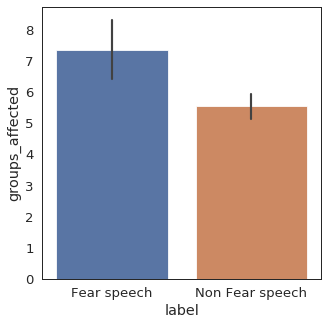

In [25]:
matplotlib.rcParams['figure.figsize'] = (5, 5)

#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=1.5)

font = {
    'weight' : 'normal',
    'size'   : 11}
ax1 = sns.barplot(x="label", y="groups_affected", data=df_num_groups)#g=add_values(g,df_admin,15,order_list)
plt.savefig('../Fear_speech_results/groups_affected.pdf',bbox_inches='tight',dpi=400)


In [26]:
num_spreader=[]
for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    pd.set_option('display.max_colwidth', 300)
    temp=whatsapp_data[whatsapp_data['orig_index'].isin(row['repeated'])]
    temp=temp.sort_values('timestamp')
    try:
        days_active= (temp.iloc[len(temp)-1]['timestamp'] - temp.iloc[0]['timestamp'])/(60*60*24*1000)
    except:
        days_active=0
    
    
    if(row['one_fear_speech']==1):
        num_spreader.append([index,days_active,'Fear speech'])
    else:
        num_spreader.append([index,days_active,'Non Fear speech'])


100%|██████████| 4782/4782 [00:31<00:00, 150.44it/s]


In [27]:
df_active=pd.DataFrame(num_spreader,columns=['msg_id','days_active','label'])


# generate two independent samples
# compare samples
stat, p = mannwhitneyu(df_active[df_active['label']=='Fear speech'].days_active, df_active[df_active['label']=='Non Fear speech'].days_active)
print('Statistics=%.3f, p=%.10f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=1844714.000, p=0.0000000008
Different distribution (reject H0)


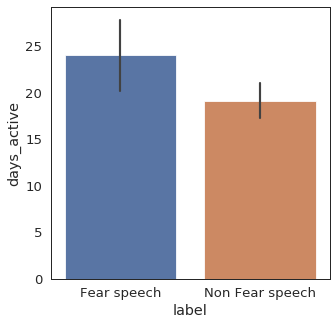

In [28]:
matplotlib.rcParams['figure.figsize'] = (5, 5)

#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=1.5)

font = {
    'weight' : 'normal',
    'size'   : 11}
ax1 = sns.barplot(x="label", y="days_active", data=df_active)
plt.savefig('../Fear_speech_results/number_of_days_active.pdf',bbox_inches='tight',dpi=400)



In [29]:
num_spreader=[]
for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    pd.set_option('display.max_colwidth', 300)
    temp=whatsapp_data[whatsapp_data['orig_index'].isin(row['repeated'])]
    if(row['one_fear_speech']==1):
        num_spreader.append([index,len(list(temp['phone_num_anonymized'].unique())),'Fear speech'])
    else:
        num_spreader.append([index,len(list(temp['phone_num_anonymized'].unique())),'Non Fear speech'])


100%|██████████| 4782/4782 [00:30<00:00, 157.31it/s]


In [30]:
df_num_users=pd.DataFrame(num_spreader,columns=['msg_id','users_who_spread','label'])

# generate two independent samples
# compare samples
stat, p = mannwhitneyu(df_num_users[df_num_users['label']=='Fear speech'].users_who_spread, df_num_users[df_num_users['label']=='Non Fear speech'].users_who_spread)
print('Statistics=%.3f, p=%.10f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')
    
    

Statistics=1798503.500, p=0.0000000000
Different distribution (reject H0)


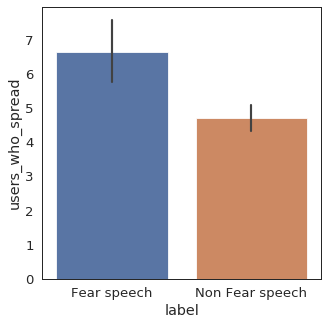

In [31]:
matplotlib.rcParams['figure.figsize'] = (5, 5)

#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=1.5)

font = {
    'weight' : 'normal',
    'size'   : 11}
ax1 = sns.barplot(x="label", y="users_who_spread", data=df_num_users)
plt.savefig('../Fear_speech_results/users_who_spread.pdf',bbox_inches='tight',dpi=400)





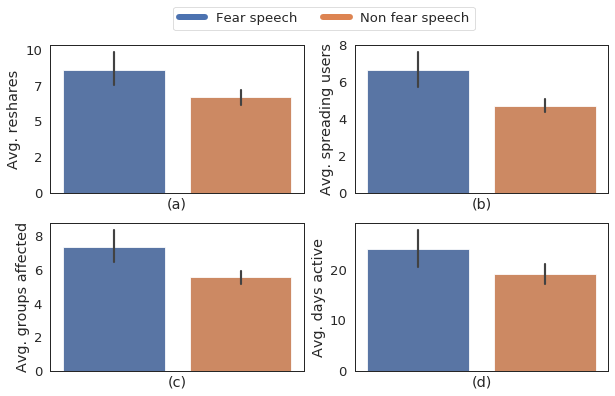

In [41]:
from matplotlib.lines import Line2D
from  matplotlib.ticker import FuncFormatter
matplotlib.rcParams['figure.figsize'] = (10, 6)

#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=1.5)

font = {
    'weight' : 'normal',
    'size'   : 11}




ax1=plt.subplot(2, 2, 1)
ax = sns.barplot(x="label", y="num_repeats",ax=ax1,data=df_repeat)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel("Avg. reshares")
plt.xlabel("(a)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))


ax2=plt.subplot(2, 2, 2)
ax = sns.barplot(x="label", y="users_who_spread",ax=ax2, data=df_num_users)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel("Avg. spreading users")

plt.xlabel("(b)")

ax3=plt.subplot(2, 2, 3)
ax = sns.barplot(x="label", y="groups_affected",ax=ax3, data=df_num_groups)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel("Avg. groups affected")

plt.xlabel("(c)")

ax4=plt.subplot(2, 2, 4)
ax = sns.barplot(x="label", y="days_active",ax=ax4, data=df_active)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel("Avg. days active")

plt.xlabel("(d)")

cmap=matplotlib.cm.get_cmap(name='tab20c')

custom_lines = [Line2D([0], [0], color=sns.color_palette()[0], lw=6),
                Line2D([0], [0], color=sns.color_palette()[1], lw=6)]


plt.legend(custom_lines, ['Fear speech', 'Non fear speech'],bbox_to_anchor=(0.5, 2.5), ncol=2)
#plt.legend(labels=['fear speech','non fear speech'], loc='center')
plt.savefig('../Fear_speech_results/total.pdf',bbox_inches='tight',dpi=400)

In [ ]:
#cmap=matplotlib.cm.get_cmap(name='tab10')
cmap(4)

In [ ]:
def distribution_of_messages(wp_data,window):
    list_messages=[]
    
    num_days=int((end_time-start_time)/(window*24*60*60*1000))
    for i in tqdm_notebook(range(num_days)):
        data_of_the_day = wp_data[wp_data['timestamp'].between(start_time+i*(window*24*60*60*1000),start_time+(i+1)*(window*24*60*60*1000) , inclusive=True)]
        for group in list(data_of_the_day['group_id_anonymized'].unique()):
            grp_per_day_data=data_of_the_day[data_of_the_day['group_id_anonymized']==group]
            #grp_per_day_data=data_of_the_day[data_of_the_day['group_id_anonymized']==group]['phone_num_anonymized'].unique()
            if(len(grp_per_day_data)>1000):
                list_messages.append([group,i,30,1])
            else:
                list_messages.append([group,i,len(grp_per_day_data),1])
    return list_messages



In [ ]:
import matplotlib
def convert(year,month,date):
    return int(datetime(year, month, date, 0, 0, 0).timestamp()*1000)

def convert_reverse(timestamp):
    dt_object = datetime.fromtimestamp(timestamp/1000)
    print("dt_object =", dt_object)
    return dt_object

matplotlib.rcParams['figure.figsize'] = (15, 6)
# font = {
#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=2.0)
window=7
list_timeline=distribution_of_messages(data_fear_speech,7)
#list_timeline_2=distribution_of_messages(whatsapp_data,7)

df_timeline=pd.DataFrame(list_timeline,columns=['user_id','timeline','num_messages','num_users'])
#df_timeline2=pd.DataFrame(list_timeline_2,columns=['user_id','timeline','num_messages','num_users'])

ax = sns.lineplot(x="timeline", y="num_messages",data=df_timeline,hue_order=['CONGRESS','BJP','AIMIM'],markers=True,dashes=False,estimator='mean')
#ax2 = sns.lineplot(x="timeline", y="num_messages",data=df_timeline2,hue_order=['CONGRESS','BJP','AIMIM'],markers=True,dashes=False,estimator='mean')

plt= add_extra_timeperiod(plt,window,start_time,end_time)
plt.xlabel('')
plt.ylabel('average number of messages')
plt.legend(['Fear speech'])

plt.savefig('../Fear_speech_results/temporal_fear_speech.pdf',bbox_inches='tight',dpi=400)
#plt.savefig('../Whatsapp_Results/hindu__muslim_messages'+str(window)+'whole_data.pdf',bbox_inches='tight',dpi=400)

plt.show() 

In [ ]:
import empath

In [ ]:
from empath import Empath
lexicon = Empath()

In [ ]:
lexicon.cats.keys()

In [ ]:
dict_map={0:'non fear speech',1:'fear speech'}

def get_empath_categories(df,normalize=False): 
    tuples=[]
    for index,row in df.iterrows():
        dict_lexicon=lexicon.analyze(row['translated'], normalize=normalize)
        try:
            temp=dict_lexicon.values()
        except AttributeError:
            dict_lexicon=lexicon.analyze("sample text", normalize=normalize)
        temp=list(dict_lexicon.values())+[index,dict_map[row['one_fear_speech']]]
        tuples.append(temp)
    df_empath=pd.DataFrame(tuples,columns=list(dict_lexicon.keys())+['org_index','label'])
    
    
    print(len(df),len(df_empath))
    df=df.reset_index(drop=True)
    #df_with_empath=pd.concat([df,df_empath],axis=1)
    return df_empath


In [ ]:
annotated_df_empath

In [ ]:
annotated_df_empath = pd.melt(annotated_df_empath,id_vars="label",var_name="category", value_name="normalized_value")


In [ ]:
annotated_df_empath=annotated_df_empath[annotated_df_empath['category']!='org_index']
annotated_df_empath.head()

In [ ]:
categories=['help', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'family', 'crime', 'masculine', 'pride', 'dispute', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'journalism', 'social_media', 'kill', 'ridicule', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'religion', 'worship', 'leader', 'independence', 'movement', 'medieval', 'death', 'legend', 'heroic', 'celebration', 'violence', 'military', 'neglect', 'love', 'order', 'sympathy', 'anonymity', 'trust', 'ancient', 'deception', 'fight', 'dominant_personality', 'politeness', 'war', 'speaking', 'listen', 'disgust', 'fire', 'gain', 'injury', 'rage', 'work', 'valuable', 'warmth', 'youth', 'sadness', 'fun', 'emotional', 'joy', 'affection', 'ugliness', 'lust', 'shame', 'torment', 'anger', 'politics', 'strength', 'technology', 'breaking', 'power', 'animal', 'terrorism', 'disappointment', 'pain', 'philosophy', 'negotiate', 'negative_emotion', 'competing', 'law', 'friends', 'achievement', 'feminine', 'weapon', 'monster', 'giving', 'contentment', 'writing', 'positive_emotion']

In [ ]:
matplotlib.rcParams['figure.figsize'] = (40, 6)

temp=annotated_df_empath[annotated_df_empath['category'].isin(categories)]
font = {
    'weight' : 'normal',
    'size'   : 11}
g = sns.barplot(x="category", y="normalized_value",hue="label",data=temp)
#g=add_values(g,df_admin,15,order_list)
#plt.ylabel('number of groups as admin')
g.set_xticklabels(
        g.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right',
        fontweight='normal',
        fontsize='medium'

    )
    
# plt.show()
plt.savefig('empath.pdf',bbox_inches='tight',dpi=400)

In [ ]:



from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
# seed the random number generator


In [ ]:
for cat in categories:
    temp=annotated_df_empath[annotated_df_empath['category']==cat]
    treatment=np.array(temp[temp['label']=='fear speech'].normalized_value)
    control=np.array(temp[temp['label']=='non fear speech'].normalized_value)
    seed(2)
    # generate two independent samples
    # compare samples
    stat, p = mannwhitneyu(treatment, control)
    print('For %s , Statistics=%.3f, p=%.3f' % (cat,stat, p))